In [1]:
import numpy as np

points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])

from scipy.spatial import Delaunay

tri = Delaunay(points)

### The two helper functions with torch implementations needed

### torch implementation of finding local maxima

In [2]:
# we need: Delaunay triangulation and 
# finding the local maxima in an image

In [3]:
import torch
import matplotlib.pyplot as plt

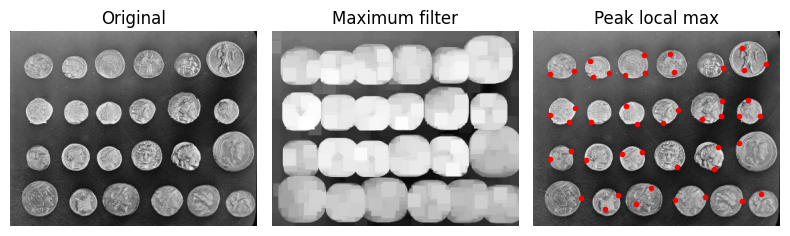

In [4]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

im = img_as_float(data.coins())

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(im, size=20, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=20)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()

In [135]:
import torch.nn.functional as F
def find_all_local_maxima(image, neighborhood_size, minimum_value=0.5):
        """
        helper function for peak_local_max that finds all the local maxima
        within each neighbourhood. (may return multiple per neighbouhood).
        """
        # Perform max pooling with the specified neighborhood size
        kernel_size = 2*neighborhood_size + 1
        pooled = F.max_pool2d(image, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)

        # Create a mask for the local maxima
        mask = (pooled == image) * (image >= minimum_value)

        # Apply the mask to the original image to retain only the local maxima values
        local_maxima = image * mask

        return local_maxima


In [182]:
def peak_local_max(image, neighbourhood_size, minimum_value):
    """
    computes peak local maxima function for an image (or batch of images), returning a maxima mask
    and the coordinates of the peak local max values.
    peak local maxima returns a image that is zero at all points other than local maxima.
    At the local maxima, the pixel retains its value in the original image.
    
    image: a torch tensor of shape [B,1,H,W] or [H,W], B is batch size. H,W are spatial dims.
    neighbourhood_size: int. Only one maxima will be selected within a square patch of width 
        equal to the neighbourhood size (specifically the largest maxima in that neighbourhood).
        Where there are multiple local maxima with the largest value within the neighbourhood,
        the maxima furthest away from the origin (furthest by euclidian distance from pixel (0,0))
        is retained (ensuring there is only one maxima per neighbourhood).
    minimum_value: float. Local maxima with pixel intensity below this value are ignored.
    
    returns: a torch tensor of shape equal to image, a list of length B containing (lx, ly) pairs
    where lx and ly are torch tensors containing the x and y coordinates of each local maxima for a given image.
    if image has shape [H,W], returns (lx, ly). 
    """
    
    assert len(image.shape) == 2 or len(image.shape) == 4
    single_image=False
    if len(image.shape) == 4:
        assert image.shape[1] == 1
    if len(image.shape) == 2:
        image = image.view(1, 1, *image.shape)
        single_image=True
        
    
    
    all_local_maxima = find_all_local_maxima(image, neighbourhood_size, minimum_value)
    
   # perform non-maximal coordinate supression to only get one maxima per neighbourhood.
    # specifically, where there are two maxima in a neighbourhood, I retain the maxima
    # which has the furthest euclidian distance away from the origin. This is just an
    # 'arbitrary' way for me to split the ties. 
    spatial_dims = [image.shape[-2], image.shape[-1]]
    grid = torch.stack(
                torch.meshgrid(
                    *[torch.arange(0, sdi, 1) for sdi in spatial_dims],
                    indexing='ij'
                )
            ).type(torch.float32).to(image.device)
    distance_to_origin = grid.unsqueeze(0).square().sum(dim=1).sqrt()
    distance_of_max_poses = all_local_maxima * distance_to_origin
    retained_maxima = find_all_local_maxima(distance_of_max_poses, neighbourhood_size, minimum_value=0)
    peak_local_max = all_local_maxima * (retained_maxima > 0)
    
    
    locs = [torch.where(lm.squeeze()) for lm in peak_local_max] # one list per image in the batch
    if single_image:
        peak_local_max = peak_loca_max.squeeze()
        locs = locs[0]
        

    return peak_local_max, locs

In [183]:
im_tensor = torch.stack([torch.Tensor(im), torch.Tensor(im).flip(-1), ]).unsqueeze(1)
maxima, locs = peak_local_max(im_tensor, neighbourhood_size=20, minimum_value=0.6)

In [184]:
im_tensor.shape, maxima.shape

(torch.Size([2, 1, 303, 384]), torch.Size([2, 1, 303, 384]))

In [185]:
maxima.unique()

tensor([0.0000, 0.7882, 0.8157, 0.8196, 0.8235, 0.8314, 0.8353, 0.8392, 0.8549,
        0.8627, 0.8784, 0.8902, 0.8941, 0.9020, 0.9059, 0.9098, 0.9137, 0.9176,
        0.9216, 0.9294, 0.9333, 0.9373, 0.9412, 0.9451, 0.9529, 0.9569, 0.9608,
        0.9686, 0.9725, 0.9765, 0.9804, 0.9882])

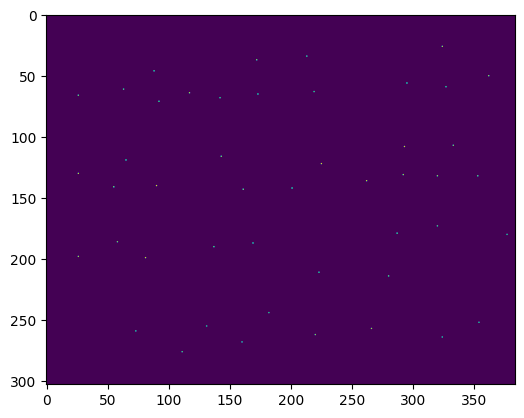

In [186]:
plt.imshow(maxima[0].squeeze())

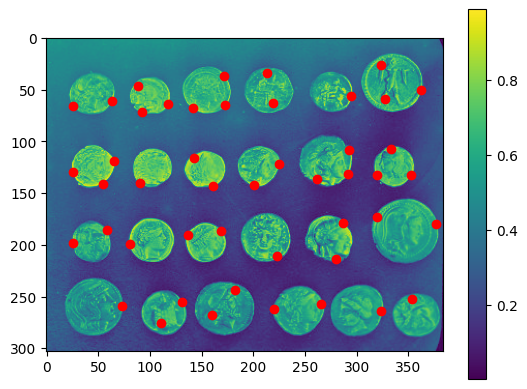

In [187]:
plt.imshow(im_tensor[0][0]); plt.colorbar()
plt.scatter(locs[0][1], locs[0][0], c='r')

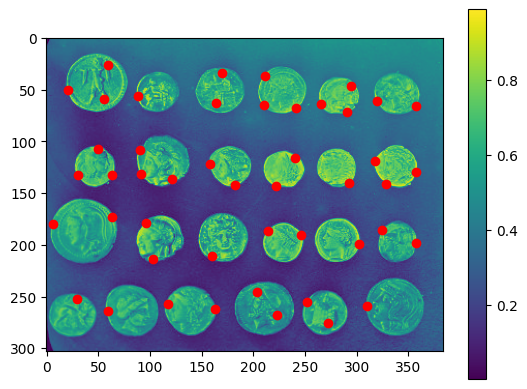

In [188]:
plt.imshow(im_tensor[1][0]); plt.colorbar()
plt.scatter(locs[1][1], locs[1][0], c='r')

In [142]:
im_tensor = torch.Tensor(im)
maxima, locs = peak_local_max(im_tensor, neighbourhood_size=20, minimum_value=0.6)

In [143]:
im_tensor.shape, maxima.shape

(torch.Size([303, 384]), torch.Size([303, 384]))

In [144]:
maxima.shape

torch.Size([303, 384])

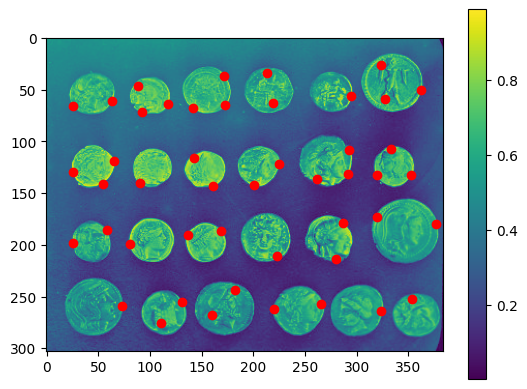

In [145]:
plt.imshow(im_tensor); plt.colorbar()
plt.scatter(locs[1], locs[0], c='r')

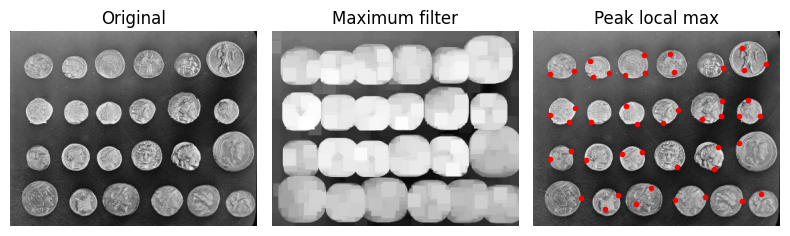

In [12]:
# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()

### torch implementation of Delaunay traingles

In [13]:
# each triangle is a vector [a, b, c] where a is a 2D point.
# the edges are a->b, b->c, c-> a


a = [1,2]
b = [10,10]
c = [5,7]
d = [20,13]
e = [17,19]
f = [8, 16]
g = [2, 15]
h = [13, 3]
i = [9, 3]
j = [18, 12]


points_list = torch.Tensor([a, b, c, d, e, f, g, h, i, j])

triangles = torch.Tensor([
    [a,b,c],
    [b,c,d],
    [d,e,f],
    [e,f,g],
    [f,g,h],
    [g,h,i],
    [h,i,j],

])

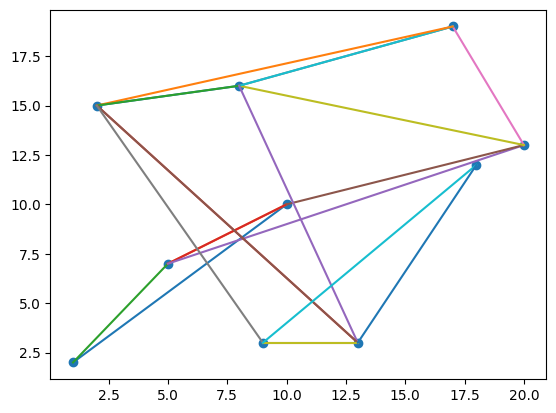

In [14]:
plt.scatter(points_list[:,0], points_list[:,1])
for triangle in triangles:
    plt.plot([triangle[0,0], triangle[1,0]], [triangle[0,1], triangle[1,1]])
    plt.plot([triangle[1,0], triangle[2,0]], [triangle[1,1], triangle[2,1]])
    plt.plot([triangle[2,0], triangle[0,0]], [triangle[2,1], triangle[0,1]])

In [15]:
def get_circumcircle(triangle):
    """
    Calculate the circumcircle of a triangle given its three vertices.
    
    Arguments:
    triangle -- a list of three tuples representing the vertices of the triangle
                Each tuple should contain the x and y coordinates of a vertex.
    
    Returns:
    center -- a tuple containing the x and y coordinates of the circumcenter
    radius -- a float representing the radius of the circumcircle
    """
    a = triangle[0]
    b = triangle[1]
    c = triangle[2]
    
    # traslate such that a is at the origin
    a_ = a - a
    b_ = b - a
    c_ = c - a
    
    ax, ay = a_
    bx, by = b_
    cx, cy = c_
    
    d = 2*(
        (bx * cy)
        - (by * cx)
    )
    
    ux = (1/d) * (
        cy * (bx.square() + by.square())
        - by * (cx.square() + cy.square())
    )
    
    uy = (1/d) * (
        bx * (cx.square() + cy.square())
        - cx * (bx.square() + by.square())
    )
    
    r = (ux.square() + uy.square()).sqrt()
    
    u = torch.stack([ux, uy])
    centre = u + a
    
    return centre, r
    


In [16]:
# Example usage
triangle = torch.Tensor([(0, 0), (1, 0), (0, 1)])
center, radius = get_circumcircle(triangle)
print("Circumcenter:", center)
print("Radius:", radius)

Circumcenter: tensor([0.5000, 0.5000])
Radius: tensor(0.7071)


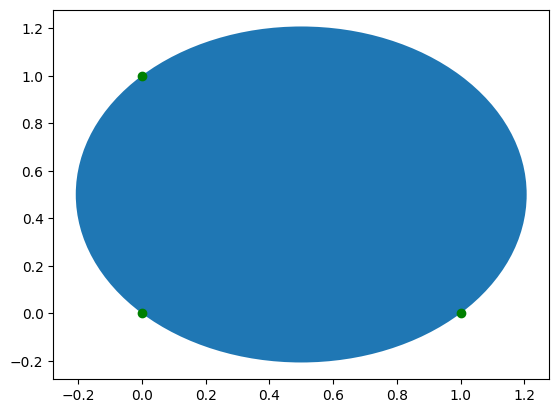

In [17]:
fig, ax = plt.subplots()
ax.add_patch(plt.Circle((0.5, 0.5), 0.7071))
plt.scatter(triangle[:,0], triangle[:,1], c='g')

### todo next steps

- [ ] find out if a triangle is delaunay
- [ ] implement the flip algorithm
- [ ] implement the random sampling / test if triangles are delaunay etc.
- [ ] see if I can calculate complexity

In [18]:
arr = torch.Tensor([1,2,3,4,5,6,7,8,9,10,5,6])
uniques = arr.unique()


### Can we have references to tensors in torch?
it seems the answer is yes

In [19]:
import torch

In [20]:
a = torch.Tensor([1,2,3])
b = torch.Tensor([3,4,5])
c = torch.Tensor([6,7,8])

triangle = [a,b,c]

traingles = {"1":triangle}

In [21]:
traingles

{'1': [tensor([1., 2., 3.]), tensor([3., 4., 5.]), tensor([6., 7., 8.])]}

In [22]:
a[0] = 5

In [23]:
triangle

[tensor([5., 2., 3.]), tensor([3., 4., 5.]), tensor([6., 7., 8.])]

### Bowyer-Watson algorithm

so the steps are:
1) find the super traingle
2) choose a random vertex to add in 
3) delete any circles that are effected and connect the new vertex to all the vertices that make up those triangles
5) repeat until there are no remaining points.

lets first get helper functions for:

- [ ] plot a set of points (orange for in the traingle grid, black for missing)
- [ ] plot a set of traingles in orange
- [ ] plot the edges of the circumcircles in light gray

In [24]:
points = torch.randn((10, 2)) * 20
random_triangles = torch.Tensor([[0,1,4], [5,2,8]]).type(torch.long)

In [25]:
[*triangles[0], triangles[0][0]]

[tensor([1., 2.]), tensor([10., 10.]), tensor([5., 7.]), tensor([1., 2.])]

In [26]:
points[triangles[0]]

IndexError: tensors used as indices must be long, int, byte or bool tensors

In [27]:
def get_super_triangle(points):
    """
    points has shape [n, 2] where n is the number of traingles.
    finds the rectangle that encloses all points and then finds a triangle that encloses that rectangle.
    This is by no means the smallest super triangle but that doesnt matter
    """
    # finding the points of the enclosing rectangle.
    # we use plus 1 and -1 to prevent us from getting degenerate triangles with infinite radius circumcircles later on
    ax = points[:,0].min() - 1
    bx = points[:,0].max() + 1
    y_top = points[:,1].max() + 1
    y_bottom = points[:,1].min() - 1
    
    # finding the points of an enclosing triangle
    x_left = ax - y_top + y_bottom
    x_right = bx + y_top - y_bottom
    x_middle = 0.5 * (ax + bx)
    y_at_x_middle = 0.5 * (bx - ax) + y_top
    
    triangle = torch.Tensor([[x_left, y_bottom], [x_middle, y_at_x_middle], [x_right, y_bottom]])
    return triangle
    

In [28]:
def plot_status(points, triangles, include_points=True, include_triangles=True, include_circumcircles=True, include_super_triangle=True, selected_point_index=None, lim=None):
    fig, ax = plt.subplots()
    if include_points:
        plt.scatter(points[:,0], points[:,1], c='gray', s=60)
    for triangle in triangles:
        if include_points:
            plt.scatter(points[triangle, 0], points[triangle, 1], c='orange', s=60)
        
        if include_triangles:
            index_loop = [*triangle, triangle[0]]
            plt.plot(points[index_loop, 0], points[index_loop, 1], c='orange', linewidth=2)
            
        if include_circumcircles:
            centre, radius = get_circumcircle(points[triangle])
            ax.add_patch(plt.Circle(centre, radius, edgecolor='black', fill=False))
            
            
    if include_super_triangle:
        super_triangle = get_super_triangle(points)
        plt.scatter(super_triangle[:,0], super_triangle[:,1], c='green', s=60)
        points_loop = torch.stack([*super_triangle, super_triangle[0]])
        # print(points_loop)
        plt.plot(points_loop[:,0], points_loop[:,1], c='green', linewidth=2)
        
    if selected_point_index != None:
            plt.scatter(points[selected_point_index][0], points[selected_point_index][1], c='red', s=200, marker='*')
    
    if lim:
        plt.xlim((-lim, lim))
        plt.ylim((-lim, lim))
    
    ax.set_aspect('equal', adjustable='box')

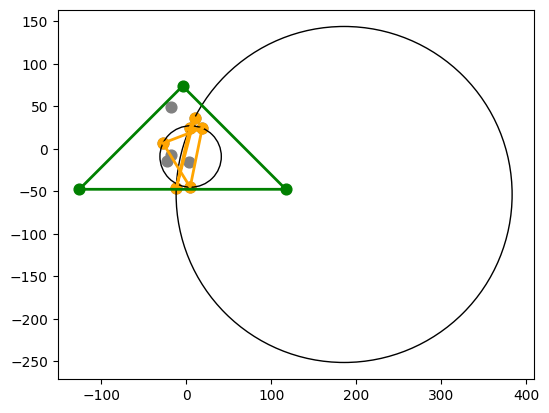

In [29]:
plot_status(points, random_triangles)

In [30]:
get_super_triangle(points)

tensor([[-125.5980,  -47.5848],
        [  -4.1821,   73.8312],
        [ 117.2339,  -47.5848]])

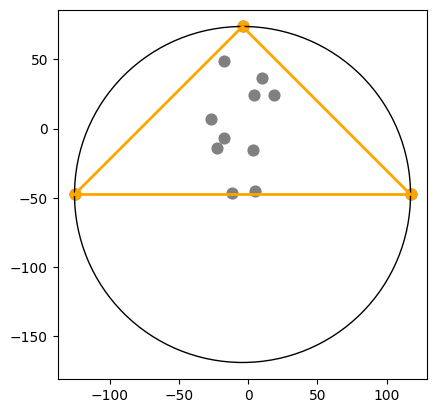

In [31]:
### Stage one: find the super triangle, add those points to the last set of points
supertriangle = get_super_triangle(points)
superpoints = torch.cat([points, supertriangle], dim=0) # superpoints is the set of points including the supertriangle points
triangles = [torch.Tensor([-3,-2,-1]).type(torch.long)] # initial set of triangles just contains the last three points

plot_status(superpoints, triangles, include_super_triangle=False)

In [32]:
triangles

[tensor([-3, -2, -1])]

In [33]:
### Stage two: setup any other initla arrays that I might need
included_point_indexes = torch.zeros(len(superpoints)).type(torch.long)
included_point_indexes[[-3,-2,-1]] = 1

In [34]:
included_point_indexes

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [35]:
### Stage three: sample a random point to pick

def choose_a_new_point(included_point_indexes):
    total_remaining_points = len(included_point_indexes) - torch.sum(included_point_indexes)
    print("total remaining: ", total_remaining_points)
    if total_remaining_points == 0:
        return None
    remaining_indices = torch.where(1 - included_point_indexes)[0]
    selected_index = remaining_indices[torch.randint(total_remaining_points, (1,)).item()]
    
    return selected_index

In [36]:
new_index = choose_a_new_point(included_point_indexes) 

total remaining:  tensor(10)


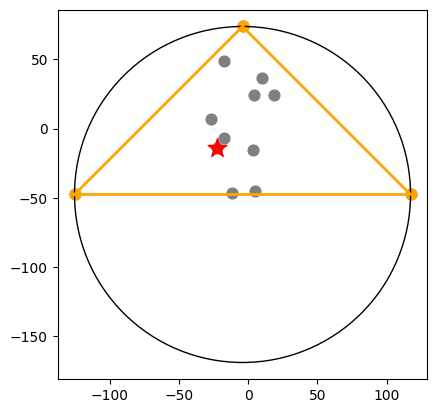

In [37]:
plot_status(superpoints, triangles, include_super_triangle=False, selected_point_index=new_index)

In [38]:
### Stage four: find all the trinagles that are not circumcircles:

def get_all_circumcircles(points, triangles):
    triangles_points = []
    for triangle in triangles:
        triangles_points.append(points[triangle])
    
    circumcircles = []
    for triangle_points in triangles_points:
        circumcircles.append(get_circumcircle(triangle_points))
    
    return circumcircles

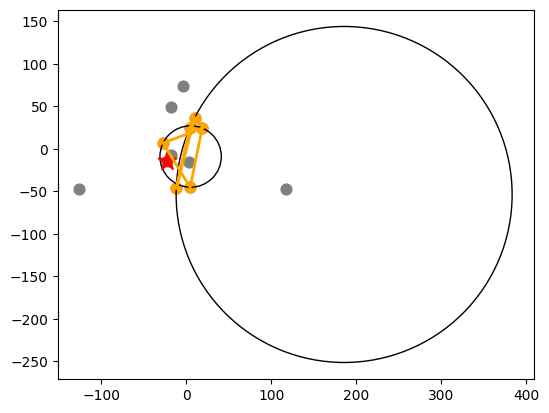

In [39]:
plot_status(superpoints, random_triangles, include_super_triangle=False, selected_point_index=new_index)

In [40]:
def determine_bad_triangles(new_point, circumcircles):
    bad_triangle_indexes = []
    for i, circumcircle in enumerate(circumcircles):
        centre, radius = circumcircle
        # print(centre, radius)
        # print(new_point - centre)
        # print((new_point - centre).square().sum().sqrt() < radius)
        if ((new_point - centre).square().sum().sqrt() < radius).sum() > 0:
            bad_triangle_indexes.append(i)
            
    return bad_triangle_indexes

In [41]:
triangles[0]

tensor([-3, -2, -1])

In [42]:
determine_bad_triangles(superpoints[new_index], get_all_circumcircles(superpoints, random_triangles))

[1]

In [43]:
bad_triangle_indexes = determine_bad_triangles(superpoints[new_index], get_all_circumcircles(superpoints, triangles))

In [44]:
bad_triangles = [triangles[bti] for bti in bad_triangle_indexes]

In [45]:
def sort_pair(a, b):
    if a < b:
        return a, b
    else:
        return b, a

In [46]:
### Stage 5: find all the edges that are not shared by multiple triangles
from collections import defaultdict
def determine_new_triangles(new_point_index, bad_triangles):
    edge_map = defaultdict(lambda : defaultdict(lambda : 0))
    for triangle in bad_triangles:
        edge = sort_pair(triangle[0].item(), triangle[1].item())
        edge_map[edge[0]][edge[1]] += 1
        edge = sort_pair(triangle[1].item(), triangle[2].item())
        edge_map[edge[0]][edge[1]] += 1
        edge = sort_pair(triangle[2].item(), triangle[0].item())
        edge_map[edge[0]][edge[1]] += 1
        
    new_triangles = []
    for edge1 in edge_map.keys():
        for edge2 in edge_map[edge1].keys():
            # print(edge1, edge2, edge_map[edge1][edge2])
            if edge_map[edge1][edge2] == 1:
                new_triangles.append(torch.Tensor([edge1, edge2, new_point_index]).type(torch.long))
                
    return new_triangles

In [47]:
determine_new_triangles(new_index, bad_triangles)

[tensor([-3, -2,  7]), tensor([-3, -1,  7]), tensor([-2, -1,  7])]

In [48]:
updated_triangles = []
for (i, t) in enumerate(triangles):
    if i not in bad_triangle_indexes:
        updated_triangles.append(triangles[i])
new_triangles = determine_new_triangles(new_index, bad_triangles)
updated_triangles += new_triangles
# updated_triangles = torch.stack(updated_triangles)

In [49]:
updated_triangles

[tensor([-3, -2,  7]), tensor([-3, -1,  7]), tensor([-2, -1,  7])]

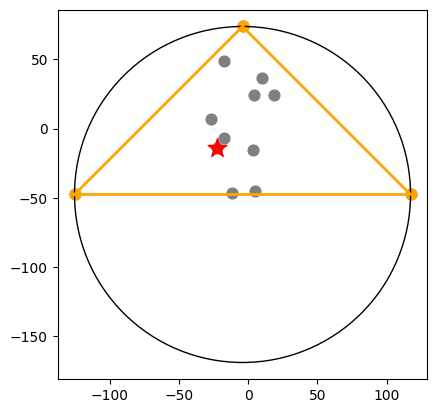

In [50]:
plot_status(superpoints, triangles, include_super_triangle=False, selected_point_index=new_index)

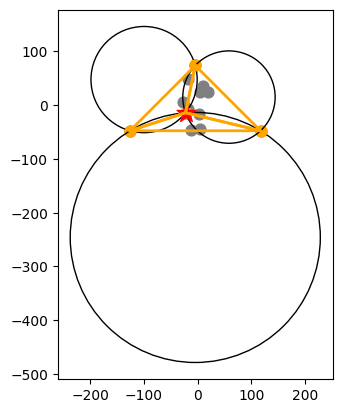

In [51]:
plot_status(superpoints, updated_triangles, include_super_triangle=False, selected_point_index=new_index)

In [52]:
print(triangles)

[tensor([-3, -2, -1])]


In [53]:
superpoints

tensor([[   9.9162,   36.3546],
        [   4.1134,   23.9830],
        [ -27.2457,    6.6630],
        [ -17.4804,   48.7675],
        [ -11.6651,  -46.5848],
        [  18.8816,   24.4020],
        [ -17.3532,   -6.8697],
        [ -22.3113,  -14.0854],
        [   4.7169,  -45.1261],
        [   3.6724,  -15.6279],
        [-125.5980,  -47.5848],
        [  -4.1821,   73.8312],
        [ 117.2339,  -47.5848]])

In [54]:
superpoints[triangles[0]]

tensor([[-125.5980,  -47.5848],
        [  -4.1821,   73.8312],
        [ 117.2339,  -47.5848]])

In [55]:
triangles

[tensor([-3, -2, -1])]

In [56]:
#get_circumcircle(superpoints[triangles[2]])

In [57]:
plt.close()

total remaining:  tensor(40)
tensor(22)
total remaining:  tensor(39)
tensor(16)
total remaining:  tensor(38)
tensor(11)
total remaining:  tensor(37)
tensor(1)
total remaining:  tensor(36)
tensor(35)
total remaining:  tensor(35)
tensor(18)
total remaining:  tensor(34)
tensor(13)
total remaining:  tensor(33)
tensor(12)
total remaining:  tensor(32)
tensor(3)
total remaining:  tensor(31)
tensor(21)
total remaining:  tensor(30)
tensor(15)
total remaining:  tensor(29)
tensor(39)
total remaining:  tensor(28)
tensor(2)
total remaining:  tensor(27)
tensor(26)
total remaining:  tensor(26)
tensor(32)
total remaining:  tensor(25)
tensor(25)
total remaining:  tensor(24)
tensor(23)
total remaining:  tensor(23)
tensor(6)
total remaining:  tensor(22)
tensor(27)
total remaining:  tensor(21)
tensor(9)
total remaining:  tensor(20)
tensor(29)
total remaining:  tensor(19)
tensor(31)


/tmp/ipykernel_30292/3901521158.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


total remaining:  tensor(18)
tensor(28)
total remaining:  tensor(17)
tensor(8)
total remaining:  tensor(16)
tensor(38)
total remaining:  tensor(15)
tensor(20)
total remaining:  tensor(14)
tensor(36)
total remaining:  tensor(13)
tensor(7)
total remaining:  tensor(12)
tensor(24)
total remaining:  tensor(11)
tensor(33)
total remaining:  tensor(10)
tensor(14)
total remaining:  tensor(9)
tensor(10)
total remaining:  tensor(8)
tensor(37)
total remaining:  tensor(7)
tensor(30)
total remaining:  tensor(6)
tensor(0)
total remaining:  tensor(5)
tensor(19)
total remaining:  tensor(4)
tensor(34)
total remaining:  tensor(3)
tensor(4)
total remaining:  tensor(2)
tensor(5)
total remaining:  tensor(1)
tensor(17)


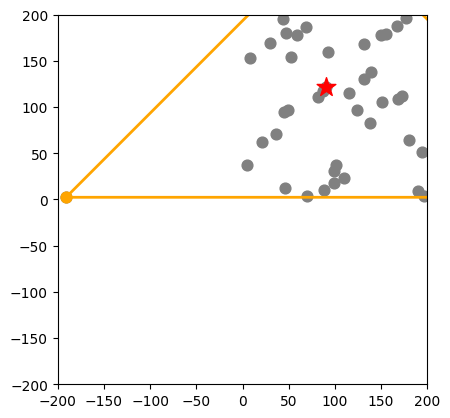

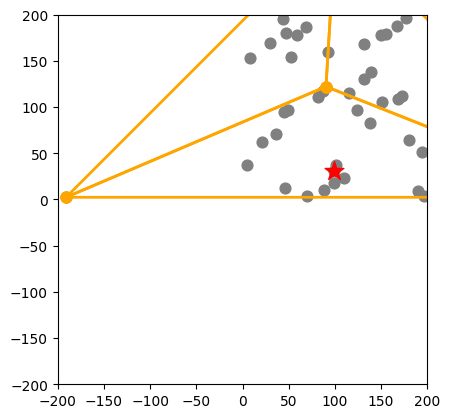

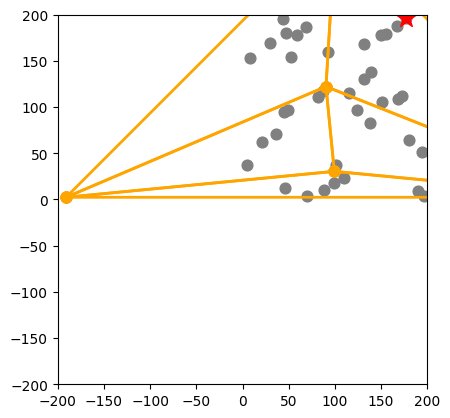

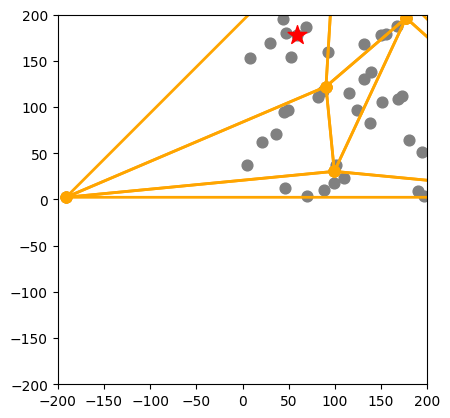

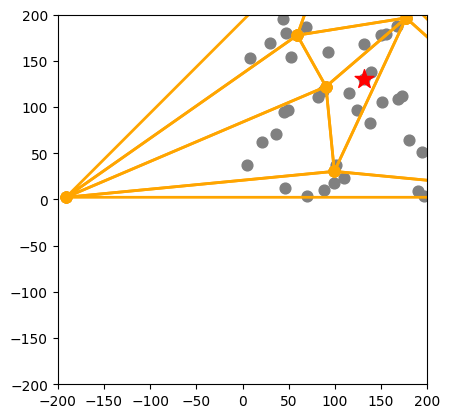

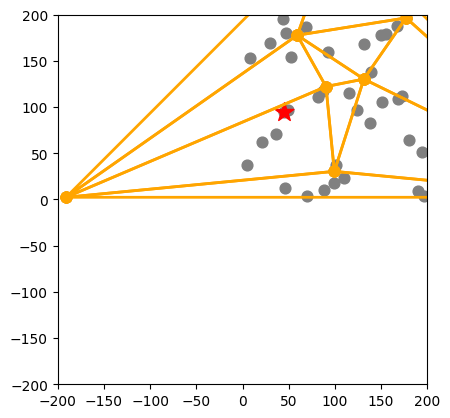

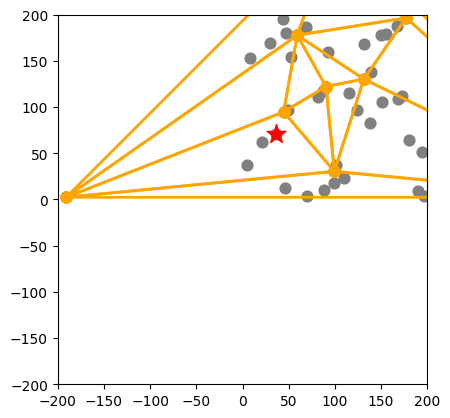

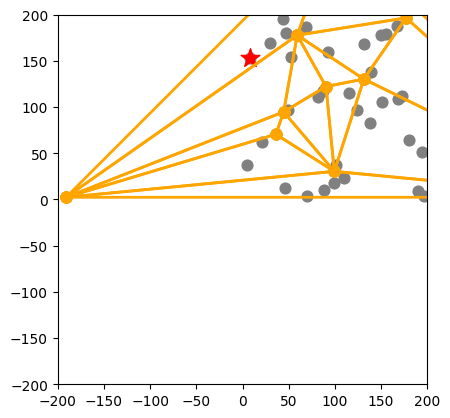

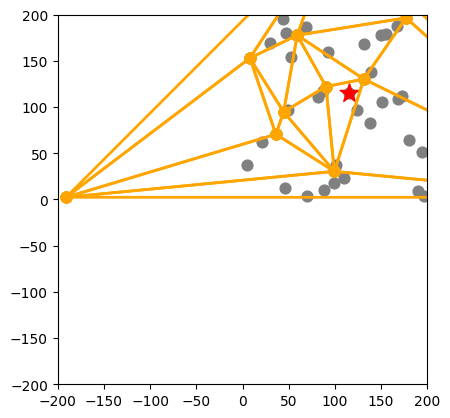

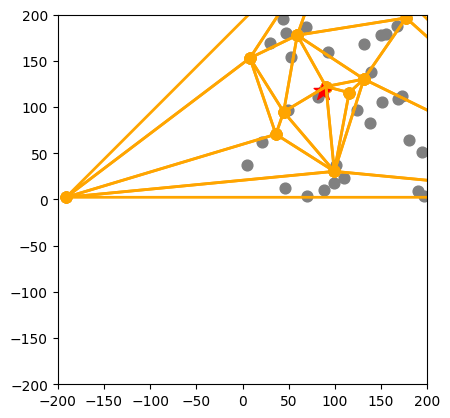

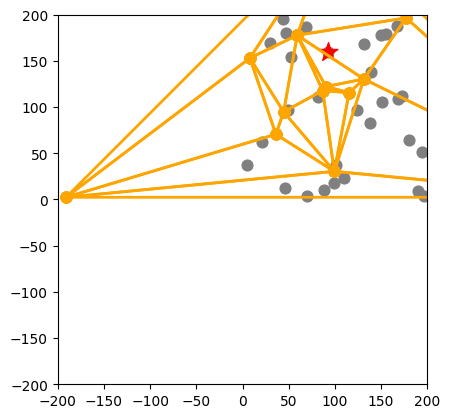

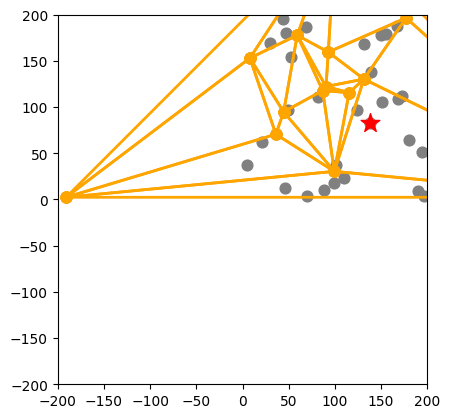

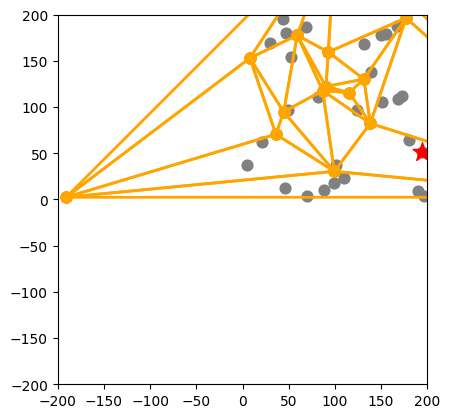

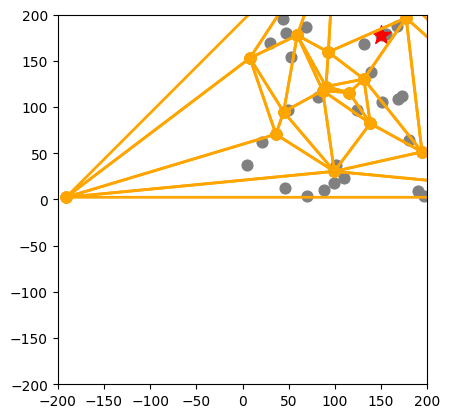

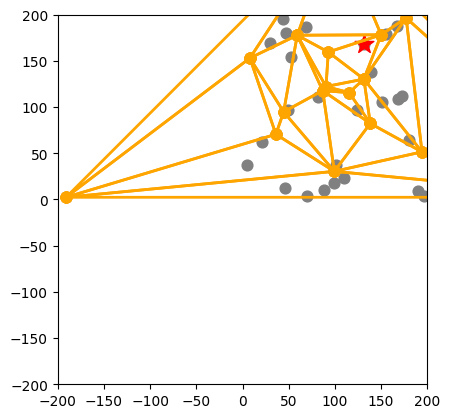

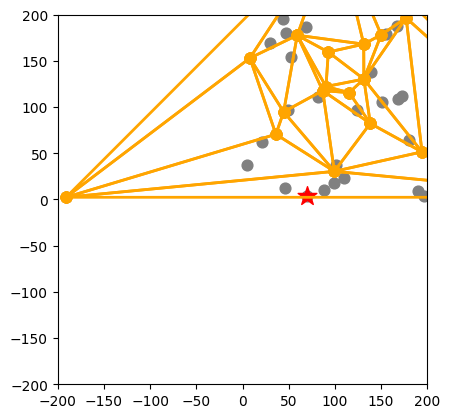

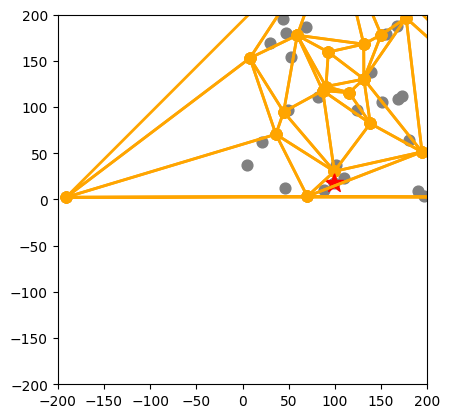

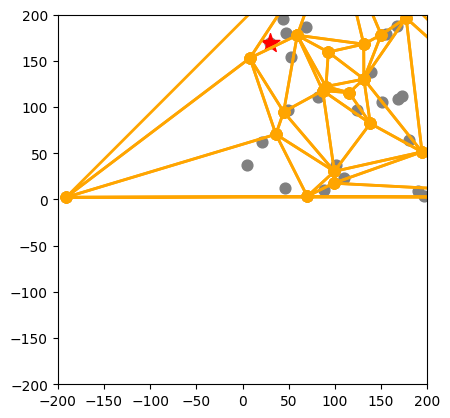

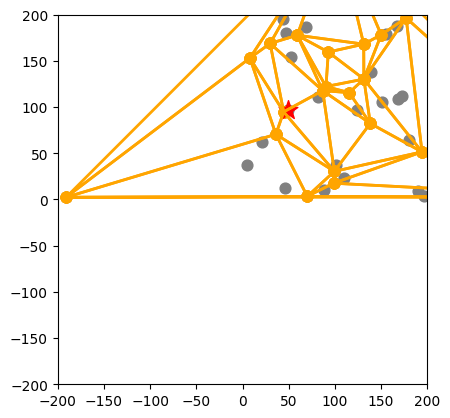

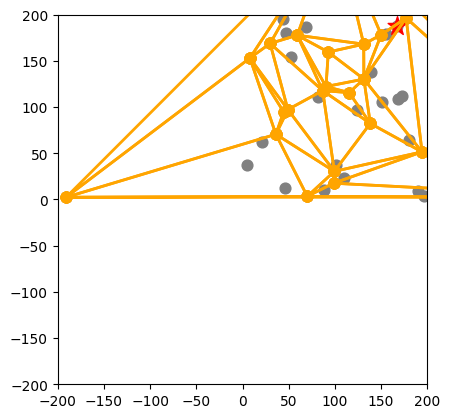

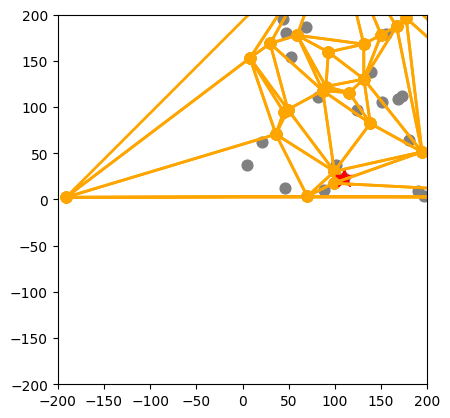

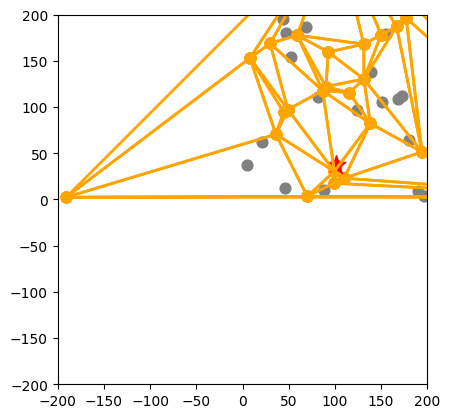

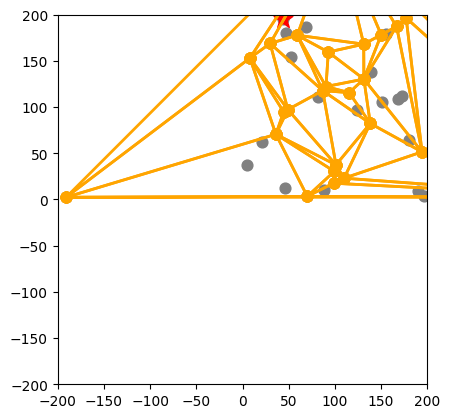

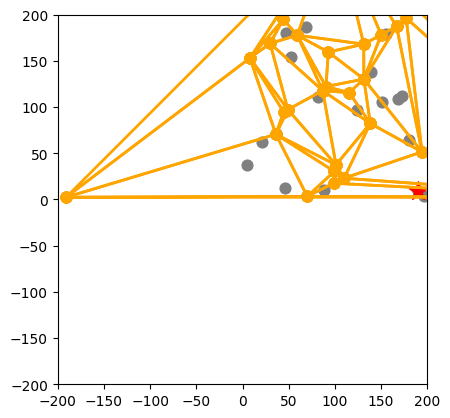

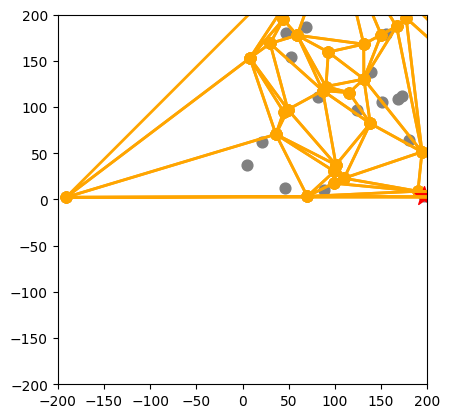

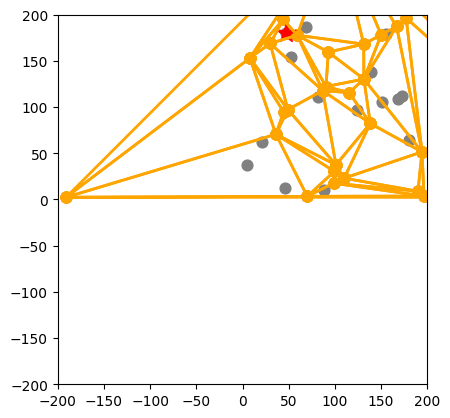

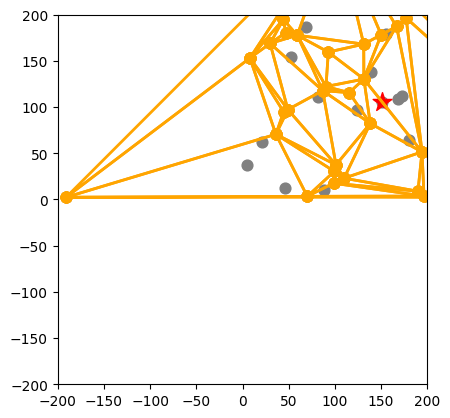

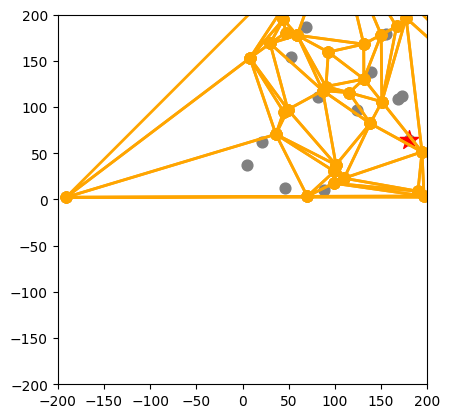

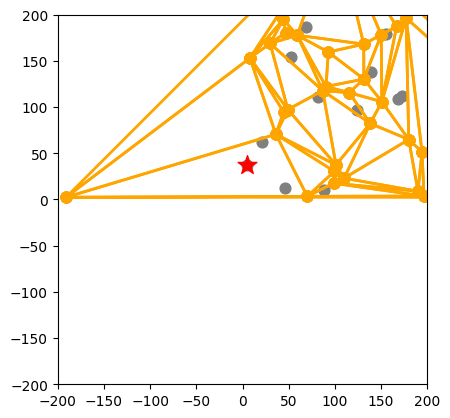

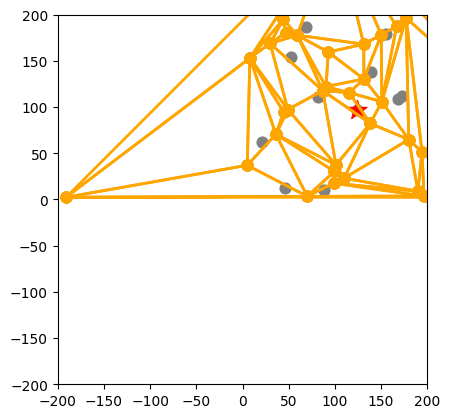

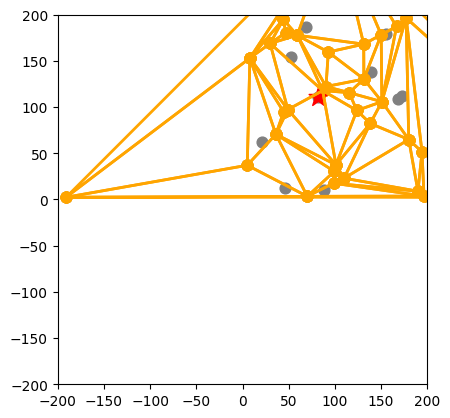

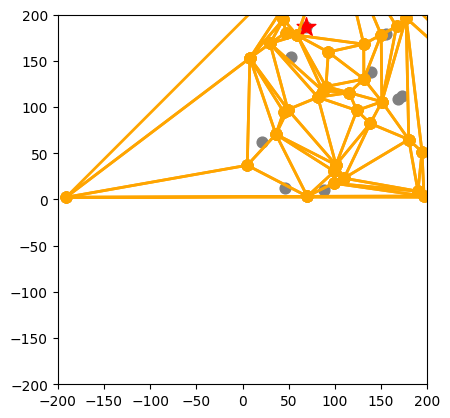

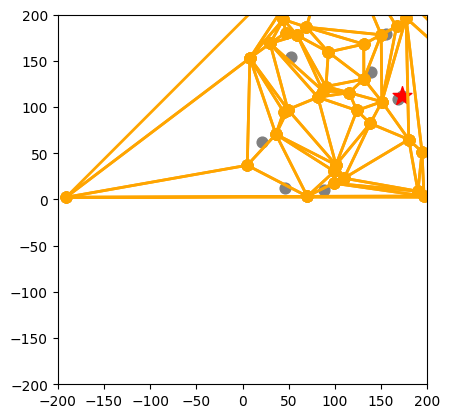

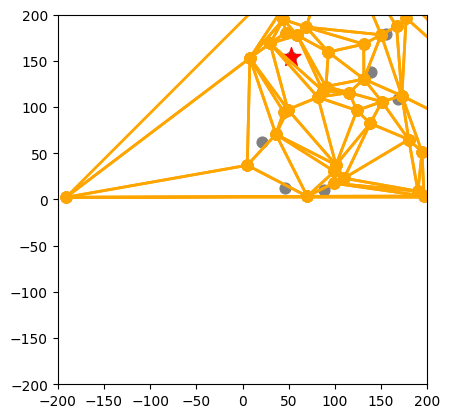

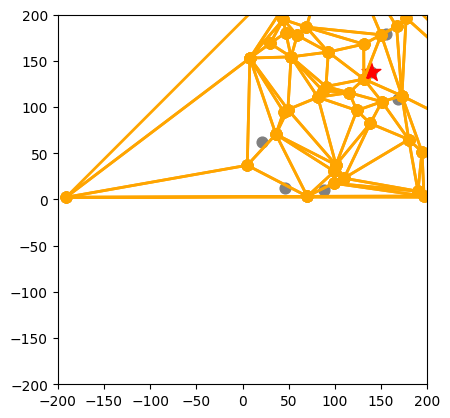

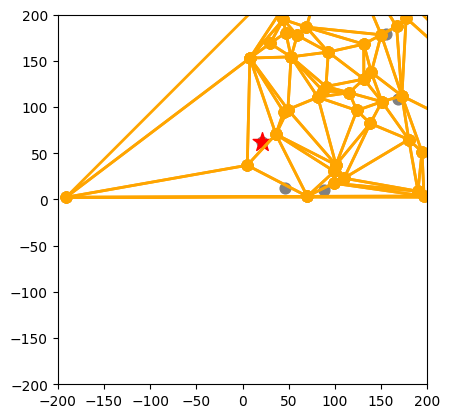

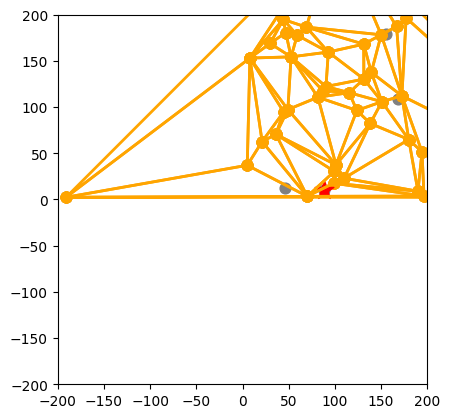

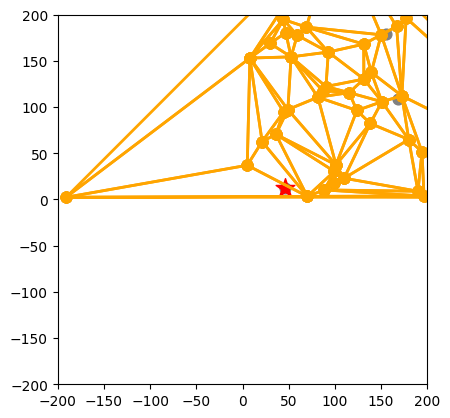

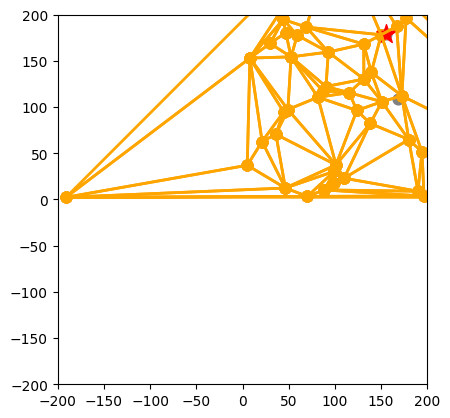

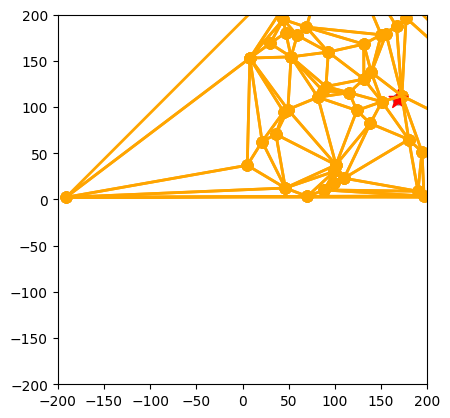

In [58]:
### okay, putting it all together:
points = torch.rand((40, 2)) * 200

supertriangle = get_super_triangle(points)
superpoints = torch.cat([points, supertriangle], dim=0) # superpoints is the set of points including the supertriangle points
triangles = [torch.Tensor([-3,-2,-1]).type(torch.long)] # initial set of triangles just contains the last three points
included_point_indexes = torch.zeros(len(superpoints)).type(torch.long)
included_point_indexes[[-3,-2,-1]] = 1

for i in range(40):
    new_index = choose_a_new_point(included_point_indexes)
    print(new_index)
    if new_index == None:
        print("BREAKING")
        break
    
    plot_status(superpoints, triangles, include_super_triangle=False, include_circumcircles=False
                , selected_point_index=new_index, lim=200)
    
    bad_triangle_indexes = determine_bad_triangles(superpoints[new_index], get_all_circumcircles(superpoints, triangles))
    bad_triangles = [triangles[bti] for bti in bad_triangle_indexes]
    # print(bad_triangle_indexes)
    
    updated_triangles = []
    for (j, t) in enumerate(triangles):
        if j not in bad_triangle_indexes:
            
            updated_triangles.append(triangles[j])
    new_triangles = determine_new_triangles(new_index, bad_triangles)
    updated_triangles += new_triangles
    updated_triangles = torch.stack(updated_triangles)
    
    triangles = updated_triangles
    included_point_indexes[new_index] = 1
    # print(updated_triangles)
    
    
    # input()
    
triangles = [t for t in triangles if -1 not in t and -2 not in t and -3 not in t]
plot_status(superpoints, triangles, include_super_triangle=False, include_circumcircles=False
                , selected_point_index=None, lim=None)

plt.close()
    
    

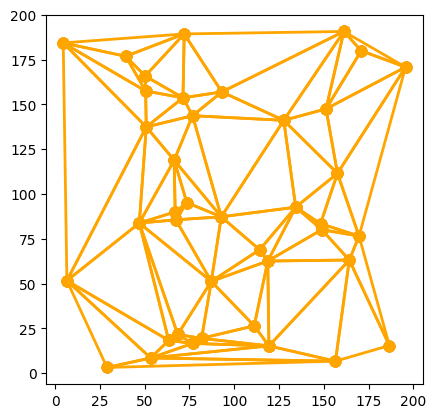

In [666]:
plot_status(points, triangles, include_super_triangle=False, include_circumcircles=False
                , selected_point_index=None, lim=None)

In [648]:
triangles

[tensor([ 2, 15,  3]),
 tensor([ 9, 15, 11]),
 tensor([ 3, 15,  1]),
 tensor([11, 15,  1]),
 tensor([ 2,  6, 17]),
 tensor([ 2, 15, 14]),
 tensor([ 9, 15, 14]),
 tensor([ 9, 14, 16]),
 tensor([ 2,  3, 18]),
 tensor([ 6, 12,  4]),
 tensor([2, 6, 4]),
 tensor([ 2, 18,  4]),
 tensor([18, 19,  4]),
 tensor([ 6, 12,  8]),
 tensor([ 6, 17,  8]),
 tensor([12, 16,  8]),
 tensor([ 3, 18,  5]),
 tensor([18, 19,  5]),
 tensor([ 9, 11, 10]),
 tensor([ 1, 11, 10]),
 tensor([1, 7, 0]),
 tensor([1, 3, 0]),
 tensor([ 5, 19,  0]),
 tensor([3, 5, 0]),
 tensor([ 7, 19,  0]),
 tensor([ 2, 17, 13]),
 tensor([ 2, 14, 13]),
 tensor([14, 16, 13]),
 tensor([ 8, 17, 13]),
 tensor([ 8, 16, 13])]